In [1]:
from pathlib import Path

import colorcet as cc
import diffrax as dfx
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from dynamical_systems.continuous import AbstractODE, Lorenz63, TangentODE
from dynamical_systems.transforms import TransformedODE
from dynamics_discovery.data import TimeSeriesDataset
from dynamics_discovery.data.loaders import (
    RandomSampleBatching,
)
from dynamics_discovery.neighborhood import (
    NeighborhoodSegmentLoader,
)
from jaxtyping import Array, Float
from matplotlib_utils.plots import colored_scatterplot


jax.config.update("jax_enable_x64", True)
plt.style.use("matplotlib_utils.styles.dash_gridded")

datadir = Path("../../data")

In [2]:
noise = 0.0
downsample = 10
dataset, transform = (
    TimeSeriesDataset.from_hdf5(datadir / "lorenz63_large.hdf5")
    .downsample(downsample)
    .add_noise(noise)
    .standardize()
)

lorenz_scaled = TransformedODE(Lorenz63(), transform)

dataset.u.shape

(5000, 1000, 3)

In [3]:
num_neighbors = 10
loader = NeighborhoodSegmentLoader(
    dataset, 2, num_neighbors, RandomSampleBatching(batch_size=1024)
)
loader_state = loader.init()
batch, loader_state = loader.load_batch(loader_state)

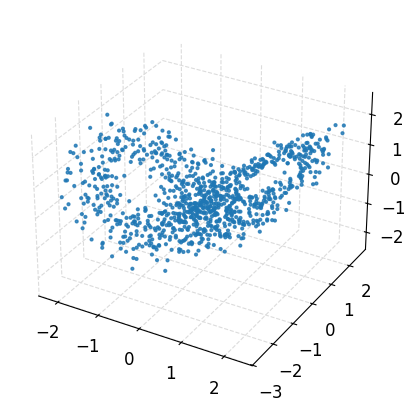

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), subplot_kw={"projection": "3d"})
scatter_kwargs = {"s": 4.0, "alpha": 0.8}
ax.scatter(*batch[1][:, 0].T, **scatter_kwargs)

In [5]:
batch[1].shape

(1024, 2, 3)

In [6]:
def tangent_evolution_matrix(
    ode: AbstractODE,
    x: Float[Array, " dim"],
    t0: float,
    t1: float,
    solver: dfx.AbstractAdaptiveSolver = dfx.Tsit5(),
    stepsize_controller: dfx.AbstractAdaptiveStepSizeController = dfx.PIDController(
        rtol=1e-7, atol=1e-9
    ),
):
    tangent_ode = TangentODE(ode)
    u0 = (x, jnp.identity(ode.dim))

    sol = dfx.diffeqsolve(
        dfx.ODETerm(tangent_ode.rhs),
        solver,
        t0,
        t1,
        None,
        u0,
        None,
        saveat=dfx.SaveAt(t1=True),
        stepsize_controller=stepsize_controller,
    )
    _, M_t = sol.ys
    return M_t[0]  # remove time dimension

In [7]:
batch[2].shape

(1024, 2, 10, 3)

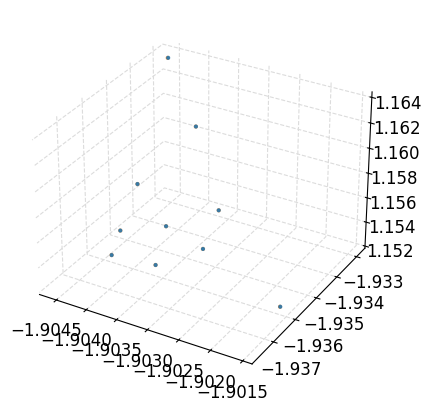

In [13]:
sample_idx=0

u0 =  batch[1][sample_idx, 0]
u_nn0 = batch[2][sample_idx, 0]

u1 =  batch[1][sample_idx, 1]
u_nn1 = batch[2][sample_idx, 1]

M = tangent_evolution_matrix(lorenz_scaled, u0, *batch[0][sample_idx])

u_nn1_pred = jnp.squeeze(M@jnp.expand_dims(u_nn0-u0, axis = -1))+u1

fig, ax = plt.subplots(1, 1, figsize=(8, 4), subplot_kw={"projection": "3d"})
scatter_kwargs = {"s": 4.0, "alpha": 0.8}
ax.scatter(*u_nn1.T, **scatter_kwargs)
ax.scatter(*u_nn1_pred.T, **scatter_kwargs)



In [12]:
u_nn1_pred.shape

(10, 3)

In [17]:
tangent_evolution_matrix(lorenz_scaled, u0, *batch[0][sample_idx])

Array([[-0.50859645,  1.24607638, -2.03562893],
       [-0.72089329,  1.72273734, -2.94054801],
       [-0.4410825 ,  1.27606559, -1.41232758]], dtype=float64)

In [126]:
M_pred = eqx.filter_vmap(
    lambda u_i: tangent_evolution_matrix(
        lorenz_scaled, u_i, 0.0, batch[0][0, 1] - batch[0][0, 0]
    )
)(batch[1][:, 0])

In [127]:
du = jnp.permute_dims(batch[2] - jnp.expand_dims(batch[1], axis=-2), axes=(0, 1, 3, 2))
du.shape

(1024, 2, 3, 10)

In [128]:
M_naive = jnp.matmul(du[:, 1], jnp.linalg.pinv(du[:, 0]))
M_naive.shape

(1024, 3, 3)

In [129]:
jnp.linalg.pinv(du[:, 0])

Array([[[  65.68881939,  -59.77449227,  -13.36828586],
        [  55.23623431,   43.52583813,   39.42699952],
        [ -93.87941359,   -3.83190484,  -12.88768095],
        ...,
        [ -37.20120388,   95.69592821,  -40.36038663],
        [  30.2701552 ,   27.47814524,   95.63690304],
        [ -25.03003445,  -81.41761406,   12.50042939]],

       [[  60.81251678,  -46.01466704, -177.99266072],
        [  75.92043828,  -73.68158404, -132.21948561],
        [  36.54862529,   77.3485459 ,  -98.70827182],
        ...,
        [ -21.69683678,   91.56702179,  -36.81930513],
        [  44.82241051,  -67.81960691,   13.69135334],
        [ 110.72755512,  155.16949709,  -52.59850252]],

       [[ -24.12495858,   24.95452077,    2.92400257],
        [ -46.75517935,   32.83759627,   37.76428499],
        [ -30.52683194,  -38.96167917,    2.84735889],
        ...,
        [  47.03636888,   26.51421011,  -55.88043052],
        [ -18.30486485,  -38.17603177,   36.12689531],
        [ -46.98536393

In [130]:
M_pred_norm = jnp.linalg.norm(M_pred, axis=(-2, -1), ord=2)
logerr = jnp.log10(
    jnp.linalg.norm(M_pred - M_naive, axis=(-2, -1), ord=2) / M_pred_norm
)

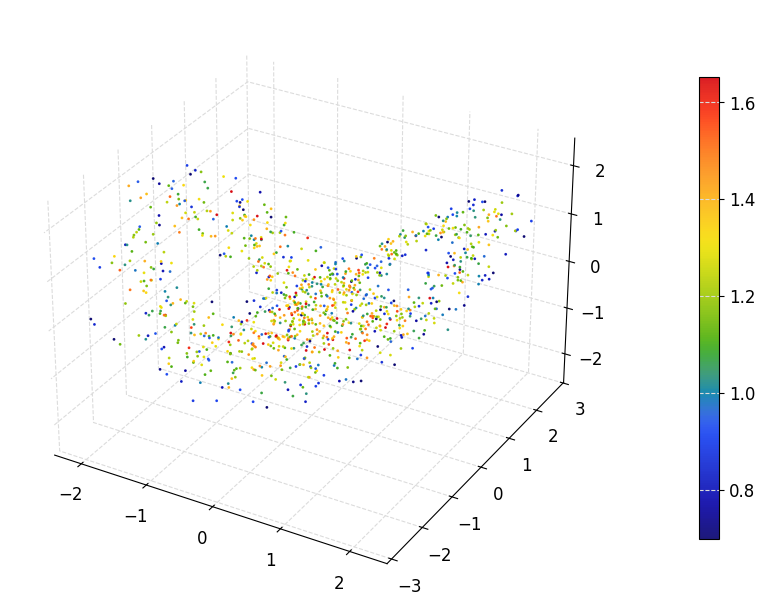

In [131]:
fig = colored_scatterplot(
    [batch[1][:, 0].T],
    [logerr],
    figsize=(10, 6),
    s=1,
    cmap=cc.cm.rainbow4,
    alpha=0.9,
)

In [132]:
Z = jnp.concatenate((du[:, 0], du[:, 1]), axis=1)
Z.shape

(1024, 6, 10)

In [133]:
U, Sigma, Vh = jnp.linalg.svd(Z, full_matrices=False)

In [134]:
U.shape

(1024, 6, 6)

In [135]:
Sigma[1]

Array([0.11452665, 0.09492587, 0.06774998, 0.00695204, 0.00319161,
       0.00137761], dtype=float64)

In [136]:
Vh.shape

(1024, 6, 10)

In [137]:
Q = jnp.permute_dims(Vh[:, :2], axes=(0, 2, 1))
Q.shape

(1024, 10, 2)

In [138]:
du0_proj = jnp.matmul(du[:, 0], Q)
du1_proj = jnp.matmul(du[:, 1], Q)
du0_proj.shape

(1024, 3, 2)

In [139]:
M_tls = jnp.matmul(du1_proj, jnp.linalg.pinv(du0_proj))
M_tls2 = jnp.matmul(U[:, 3:], jnp.linalg.pinv(U[:, 0:3]))

In [140]:
M_tls2.shape

(1024, 3, 3)

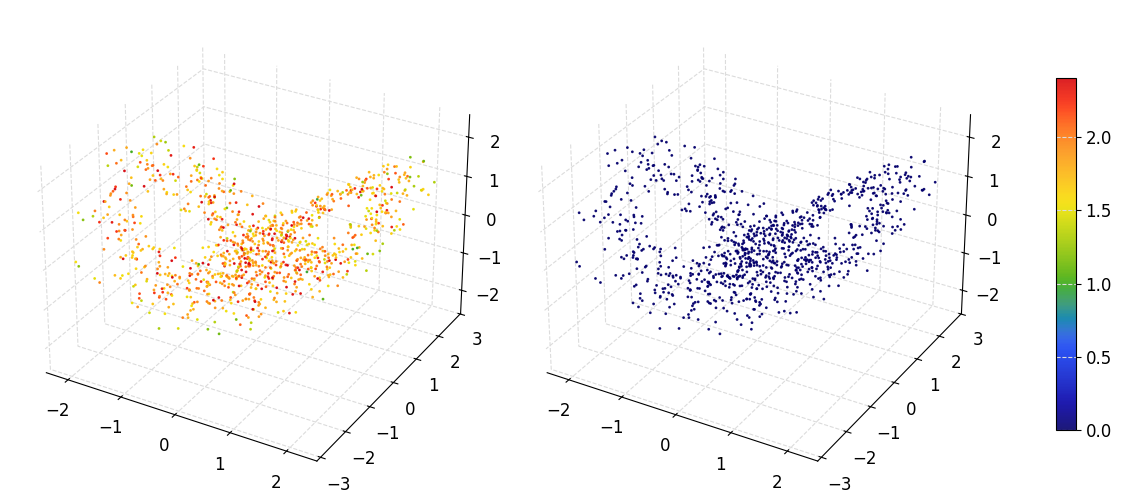

In [141]:
logerr2 = jnp.log10(jnp.linalg.norm(M_pred - M_tls, axis=(-2, -1), ord=2) / M_pred_norm)
logerr3 = jnp.log10(
    jnp.linalg.norm(M_pred - M_tls2, axis=(-2, -1), ord=2) / M_pred_norm
)
fig = colored_scatterplot(
    [batch[1][:, 0].T] * 2,
    [logerr2, logerr3],
    figsize=(10, 6),
    s=1,
    cmap=cc.cm.rainbow4,
    alpha=0.9,
)

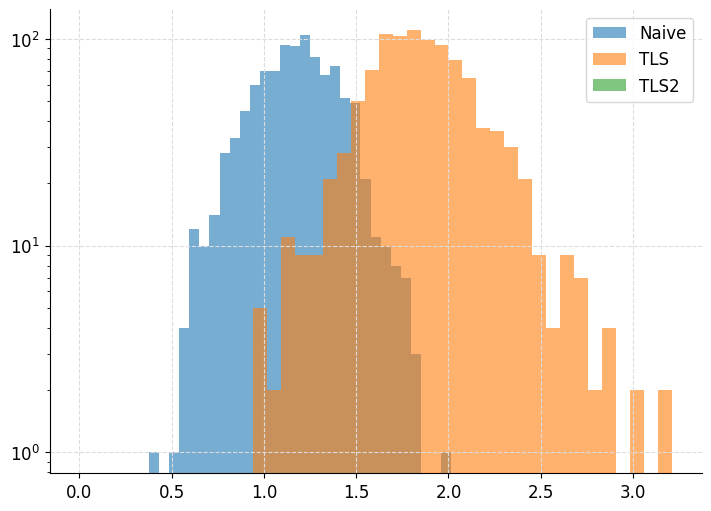

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.hist(logerr, bins=30, label="Naive", alpha=0.6)
ax.hist(logerr2, bins=30, label="TLS", alpha=0.6)
ax.hist(logerr3, bins=30, label="TLS2", alpha=0.6)
ax.legend()
ax.set_yscale("log")

In [113]:
logerr3

Array([ 3.85730987e-16,  0.00000000e+00,  1.92865493e-16, ...,
       -2.89298240e-16, -9.64327467e-17,  2.89298240e-16], dtype=float64)

In [179]:
M_true = M_pred